In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.utils import collatev2
import winsound
from project.utils import compute_statistics

d:\Programming Files\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
dte = dtt.now().strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_06_2024_205918'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import torch
import nibabel as nib
import cv2

def get_transform(height, width, p, rpn_mode):
    if rpn_mode is False:
        return A.Compose(
            [
                A.Resize(
                    height=height, 
                    width=width, 
                    p=p, 
                    always_apply=True
                ),
                ToTensorV2(p=p)
            ],
            is_check_shapes=False
        )
    else:
        return A.Compose(
            [
                A.Resize(
                    height=height, 
                    width=width, 
                    p=p, 
                    always_apply=True
                ),
                ToTensorV2(p=p)
            ],
            p=p,
            bbox_params=A.BboxParams(
                format='pascal_voc',
                min_area=0,
                min_visibility=0,
                label_fields=['labels']
            )
        )

class NiftiToTensorTransform:
    def __init__(self, target_shape=(512,512), in_channels=1, rpn_mode=False, normalization=None):
        self.target_shape = target_shape
        self.in_channels = in_channels
        self.transform = get_transform(
            height=target_shape[0],
            width=target_shape[1],
            p=1.0,
            rpn_mode=rpn_mode
        )
        self.rpn_mode = rpn_mode
        self.normalization = normalization
        
    def convert_to_binary_mask(self, segmentation_mask):
        binary_mask = (segmentation_mask > 0).astype(np.uint8)
        return binary_mask

    def extract_bounding_boxes(self, mask):
        # Extract bounding boxes from mask
        boxes = []
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x-30, y-30, x + w+30, y + h+30])
        return boxes
    
    def normalize_slice(self, slice):
        # mean, std = self.normalization
        # slice = (slice - mean) / std
        min, max = self.normalization
        slice = (slice - min) / (max - min)
        
        return slice

    def __call__(self, mri_image_path, segmentation_mask_path):
        try:
            mri_image = nib.load(mri_image_path).get_fdata()
            segmentation_mask = nib.load(segmentation_mask_path).get_fdata()
            
            if self.normalization is not None:
                mri_image = np.stack([self.normalize_slice(mri_image[:, :, i]) for i in range(mri_image.shape[2])], axis=-1)
                
            segmentation_mask = self.convert_to_binary_mask(segmentation_mask) # USE THIS
            
            image_slices = []
            mask_slices = []
            
            if self.rpn_mode == False:
                for i in range(mri_image.shape[2]):
                    augmented = self.transform(
                        image=mri_image[:, :, i], 
                        mask=segmentation_mask[:, :, i]
                    )
                
                    image_slices.append(augmented['image'].unsqueeze(0)) 
                    mask_slices.append(augmented['mask'].unsqueeze(0))   
    
                image = torch.stack(image_slices) 
                mask = torch.stack(mask_slices)  
            
                if image.shape[1] != 1 or mask.shape[1] != 1:
                    raise ValueError("Unexpected number of slices in the MRI image or segmentation mask.")

                return image, mask

            else: # RPN transformation
                for i in range(mri_image.shape[2]):
                    boxes = self.extract_bounding_boxes(segmentation_mask[:, :, i])
                    if boxes:
                        augmented = self.transform(
                            image=mri_image[:, :, i],
                            bboxes=boxes,
                            labels=[1]*len(boxes)
                        )
                        img_slice = augmented['image']
                        boxes = torch.tensor(augmented['bboxes'])
                        labels = augmented['labels']
                    else:
                        augmented = self.transform(
                            image=mri_image[:, :, i],
                            bboxes=[],
                            labels=[]
                        )
                        img_slice = augmented['image']
                        boxes = torch.tensor([0] * 4, dtype=torch.float32).unsqueeze(0)
                        labels = augmented['labels']

                    if boxes.shape[0] == 1:
                        image_slices.append(img_slice.unsqueeze(0))
                        boxes = torch.clamp(boxes, min=0, max=self.target_shape[0])
                        mask_slices.append(boxes.unsqueeze(0))
                    else: # if there are more than one bbox coordinates for a slice
                        # print('MULTIPLE BOXES FOUND')
                        # print(boxes)
                        image_slices.append(img_slice.unsqueeze(0))
                        max_x = boxes[0, 0]
                        max_y = boxes[0, 1]
                        max_w = boxes[0, 2]
                        max_h = boxes[0, 3]
                        for i in boxes[1:]:
                            x, y, w, h = i
                            if x < max_x:
                                max_x = x
                            if y < max_y:
                                max_y = y
                            if w > max_w:
                                max_w = w
                            if h > max_h:
                                max_h = h
                            # mask_slices.append(i.unsqueeze(0).unsqueeze(0))

                        bbox = torch.tensor([max_x, max_y, max_w, max_h])
                        bbox = torch.clamp(bbox, min=0, max=self.target_shape[0])
                        # print('============== FINAL BOX')
                        # print(bbox)
                        mask_slices.append(bbox.unsqueeze(0).unsqueeze(0))

                image = torch.stack(image_slices) 
                mask = torch.stack(mask_slices)  
            
                if image.shape[1] != 1 or mask.shape[1] != 1:
                    raise ValueError("Unexpected number of slices in the MRI image or segmentation mask.")

                return image, mask
        
        except Exception as e:
            print(f"Error in __call__ with {mri_image} and {segmentation_mask}: {e}")
            return None, None


### Config for fitter


In [5]:
from project.model import RPN

config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        nh=4,
        pretrained=True
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 50,
    # 'loss': nn.SmoothL1Loss(),
    'loss': nn.MSELoss(),
    # 'loss': nn.L1Loss(),
    'lr': 0.0001
}

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Load dataset


In [6]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 7)

In [7]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice,cohort,max_value
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273
...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000


### `DataLoader` Generator


In [8]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [9]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None
                ):
    data = data[data.cohort == cohort]
    # data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    # train_loader = DataLoader(
    #     train_set,
    #     shuffle=True,
    #     batch_size=batch_size,
    #     collate_fn=collatev2
    # )
    # val_loader = DataLoader(
    #     val_set,
    #     shuffle=True,
    #     batch_size=batch_size,
    #     collate_fn=collatev2
    # )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

### Fitter


In [10]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
            
            # del losses, Y, T
            # torch.cuda.empty_cache()
            # logger.info(f'MEMORY after CLEARING MEMORY\t{memcheck()}')
        
        return loss_history
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        return loss_history
                

In [11]:
fitter = RPNFitter(config, logger=logger)

### Training


In [12]:
t1, v1 = make_loaders(
    data=data,
    cohort=1,
    batch_size=4
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 7), (9, 7))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)



In [13]:
# t2, v2 = make_loaders(
#     data=data,
#     cohort=2,
#     batch_size=4
# )

In [14]:
t3, v3 = make_loaders(
    data=data,
    cohort=3,
    batch_size=4
)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 7), (10, 7))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 664.0)



In [15]:
from torch.utils.data import ConcatDataset

train_set = ConcatDataset([t1, t3])
val_set = ConcatDataset([v1, v3])

In [ ]:
tl = DataLoader(
    train_set,
    shuffle=True,
    batch_size=20,
    collate_fn=collatev2
)
vl = DataLoader(
    val_set,
    shuffle=True,
    batch_size=20,
    collate_fn=collatev2
)


Runtime: 328m 1.9s


In [17]:
thist, vhist = fitter.fit(tl, vl)

INFO:kess:EPOCH 0 ==============================
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
d:\Programming Files\Python\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
INFO:kess:Batch:	1/8
INFO:kess:Batch samples:	10
INFO:kess:Current error:	0.0934438407421112

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) shou

In [18]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

<Axes: >

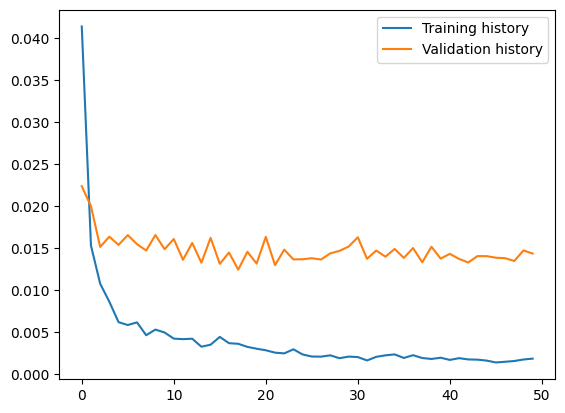

In [19]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1), label='Training history')
sns.lineplot(vh.mean(1), label='Validation history')

### Save the weights


# Summary

Trained using bboxes that have a padding of 50 or more. Improved the model but it seems like cheating to get the metrics up

Decision for which embedder to use is also decided here

TODO:

- multiple bounding box proposal
- start with vit optimizations


# Trial


In [20]:
model = fitter.model

In [21]:
sample = next(enumerate(vl))

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [22]:
slices, masks, target, case = sample[1][1]

In [23]:
x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
T = masks.squeeze(1).float().to(device)

In [24]:
y = model(x, target)

In [25]:
y

tensor([[0.1646, 0.3190, 0.3794, 0.6245]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [26]:
fitter.loss(y, T[target])

tensor(24075.2148, device='cuda:0', grad_fn=<MseLossBackward0>)

In [27]:
masks[target]

tensor([[[131.2500,  94.9219, 205.0781, 168.7500]]], dtype=torch.float64)

In [28]:
y

tensor([[0.1646, 0.3190, 0.3794, 0.6245]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [29]:
bbox = masks[target].squeeze().cpu().long()

In [30]:
y = (y*300).squeeze().detach().cpu().long()

In [31]:
bbox, y

(tensor([131,  94, 205, 168]), tensor([ 49,  95, 113, 187]))

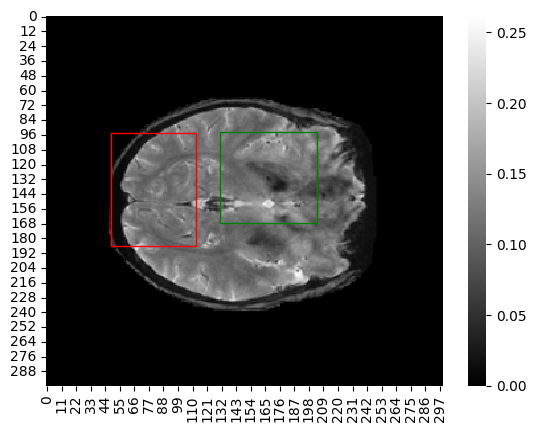

In [32]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

ax = sns.heatmap(x[target][0].squeeze().cpu(), cmap='gray')

truth = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1, edgecolor='g', facecolor='none'
)

pred = patches.Rectangle(
    (y[0], y[1]),
    y[2] - y[0],
    y[3] - y[1],
    linewidth=1, edgecolor='r', facecolor='none'
)

ax.add_patch(truth)
ax.add_patch(pred)
plt.show()

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Ground truth bounding boxes: [[[130.078125  99.609375 202.734375 173.4375  ]]]
Predicted bounding boxes: [[104.60834503173828, 89.95238494873047, 193.09910583496094, 166.43003845214844]]


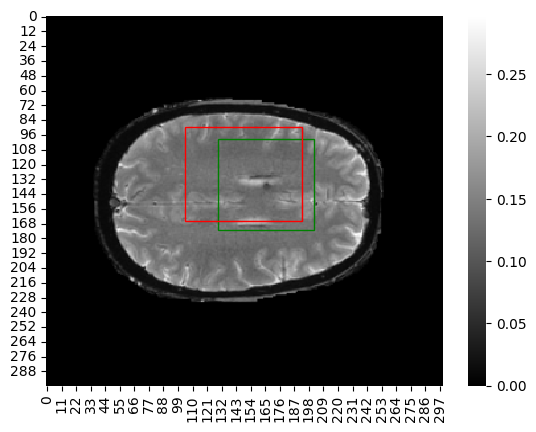

Ground truth bounding boxes: [[[ 28.125      80.859375  123.6328125 151.171875 ]]]
Predicted bounding boxes: [[81.47083282470703, 106.71077728271484, 143.0484619140625, 175.74159240722656]]


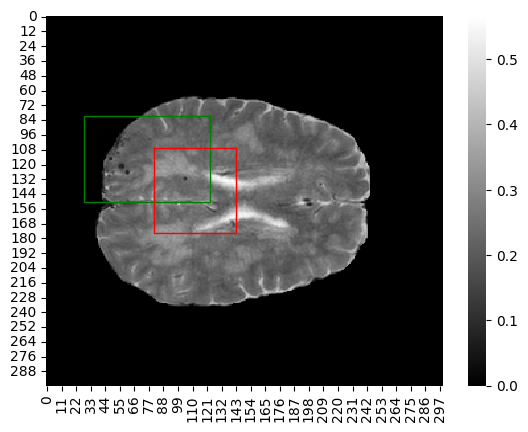

Ground truth bounding boxes: [[[ 69.140625 171.09375  141.796875 243.75    ]]]
Predicted bounding boxes: [[73.79957580566406, 111.0282211303711, 149.80096435546875, 192.42254638671875]]


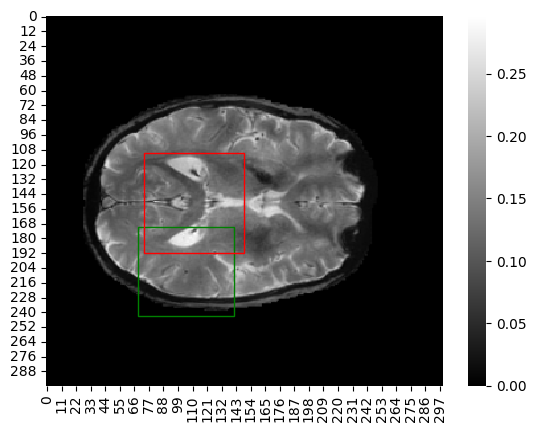

Ground truth bounding boxes: [[[131.25      94.921875 205.078125 168.75    ]]]
Predicted bounding boxes: [[49.377201080322266, 95.70091247558594, 113.81148529052734, 187.34652709960938]]


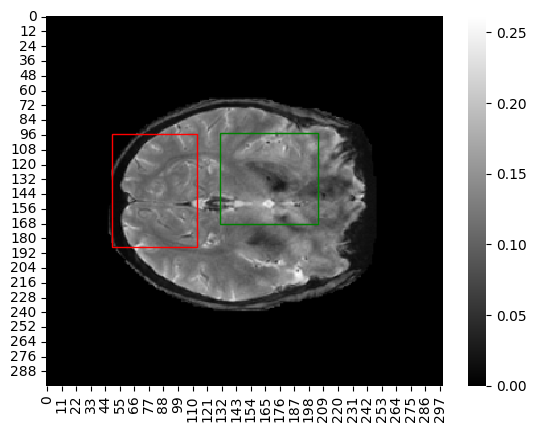

Ground truth bounding boxes: [[[ 75.       106.640625 113.671875 145.3125  ]]]
Predicted bounding boxes: [[44.18605422973633, 73.76985168457031, 136.80226135253906, 167.8040771484375]]


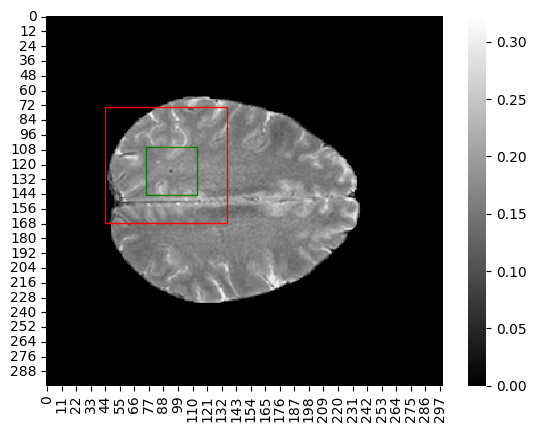

Ground truth bounding boxes: [[[ 55.078125  103.7109375 102.5390625 155.859375 ]]]
Predicted bounding boxes: [[80.49030303955078, 109.71343231201172, 132.58836364746094, 174.5326385498047]]


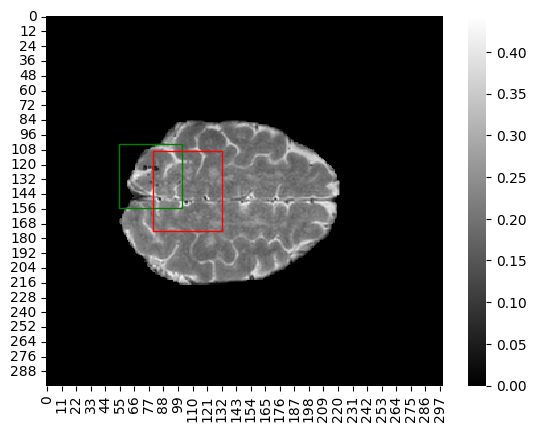

Ground truth bounding boxes: [[[ 51.5625  93.75    89.0625 131.25  ]]]
Predicted bounding boxes: [[72.47236633300781, 113.56311798095703, 111.91685485839844, 176.3507843017578]]


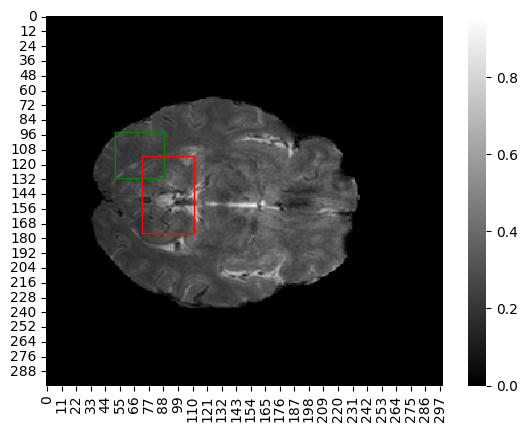

Ground truth bounding boxes: [[[ 93.75      71.484375 165.234375 144.140625]]]
Predicted bounding boxes: [[113.91553497314453, 87.85480499267578, 195.3024444580078, 163.0538330078125]]


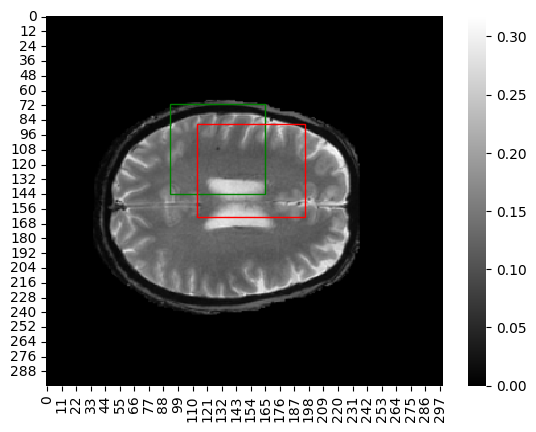

Ground truth bounding boxes: [[[ 32.2265625 162.890625   69.7265625 200.390625 ]]]
Predicted bounding boxes: [[89.13444519042969, 130.88328552246094, 97.01544952392578, 182.6545867919922]]


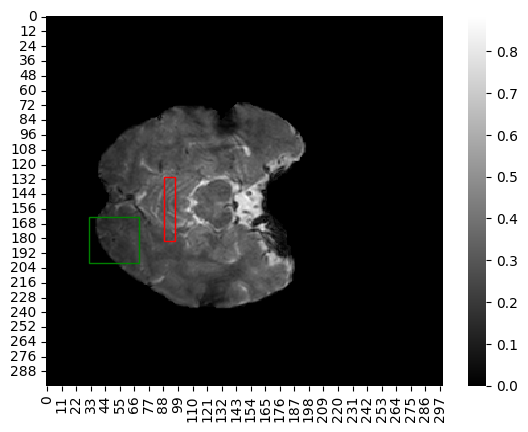

Ground truth bounding boxes: [[[ 29.296875 139.453125 103.125    213.28125 ]]]
Predicted bounding boxes: [[47.92164611816406, 106.68828582763672, 97.64899444580078, 192.26809692382812]]


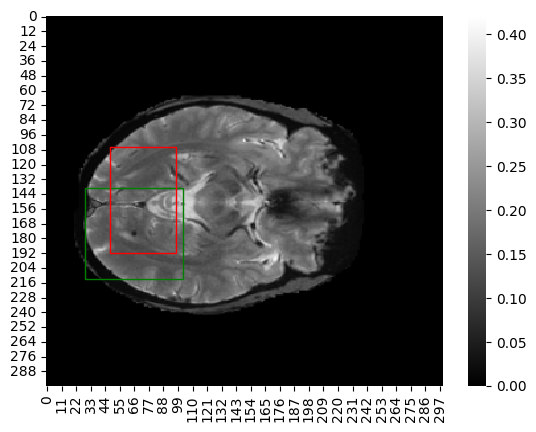

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Ground truth bounding boxes: [[[116.015625  76.171875 192.1875   151.171875]]]
Predicted bounding boxes: [[95.42086791992188, 105.7723388671875, 147.45626831054688, 176.35960388183594]]


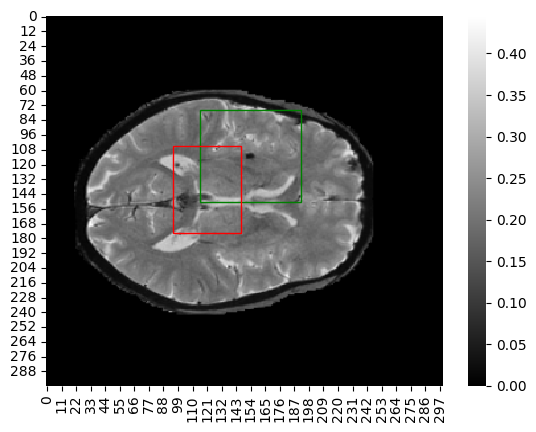

Ground truth bounding boxes: [[[ 46.2890625 105.46875   120.703125  163.4765625]]]
Predicted bounding boxes: [[73.25482940673828, 104.365478515625, 125.12730407714844, 167.1698760986328]]


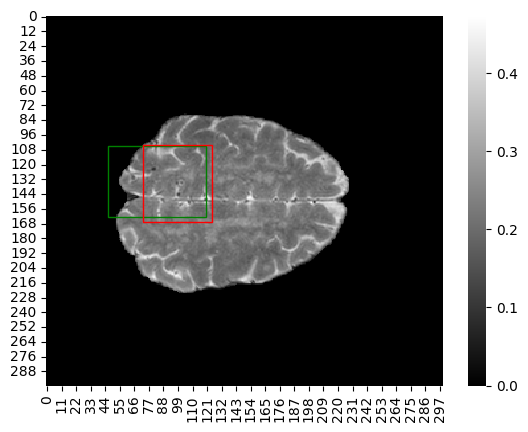

Ground truth bounding boxes: [[[ 32.8125     71.484375   90.8203125 164.6484375]]]
Predicted bounding boxes: [[65.24126434326172, 106.2722396850586, 136.2650604248047, 167.28526306152344]]


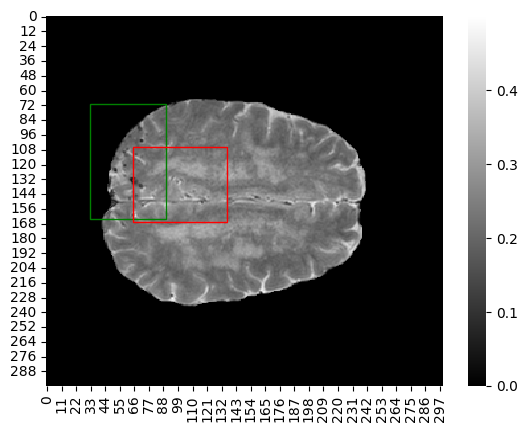

Ground truth bounding boxes: [[[136.5234375 180.46875   174.0234375 218.5546875]]]
Predicted bounding boxes: [[93.07654571533203, 133.9773712158203, 139.0618133544922, 185.91238403320312]]


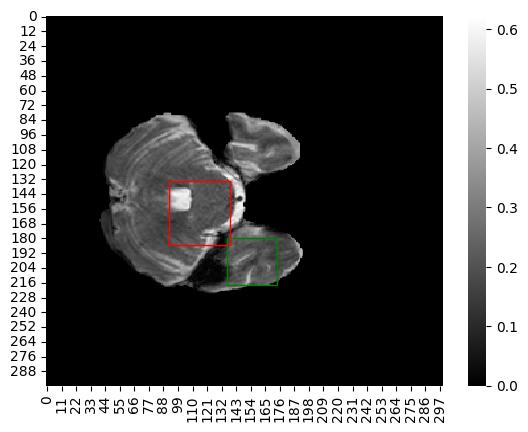

Ground truth bounding boxes: [[[133.59375  142.96875  209.765625 217.96875 ]]]
Predicted bounding boxes: [[98.31582641601562, 107.07770538330078, 183.24267578125, 173.47723388671875]]


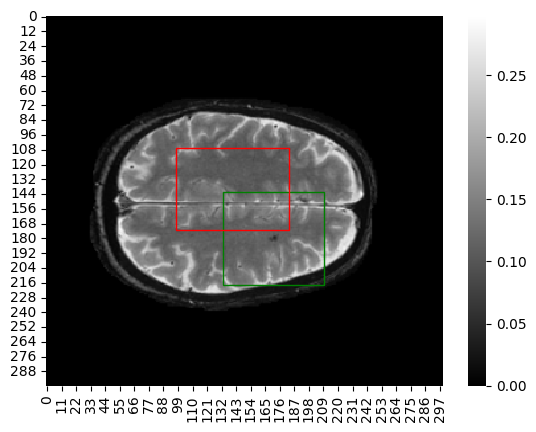

Ground truth bounding boxes: [[[ 69.140625 147.65625  141.796875 220.3125  ]]]
Predicted bounding boxes: [[89.01280212402344, 86.00363159179688, 164.2050018310547, 164.8727264404297]]


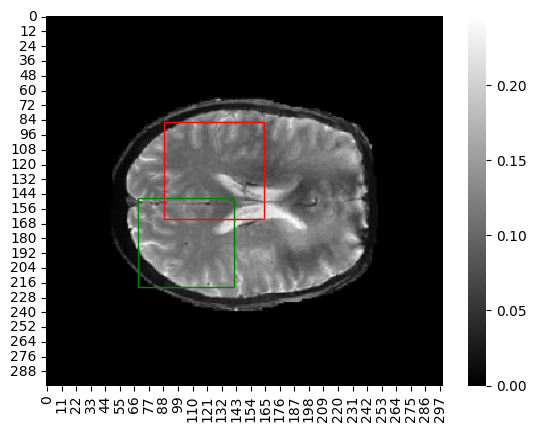

Ground truth bounding boxes: [[[131.25      159.9609375 168.75      198.046875 ]]]
Predicted bounding boxes: [[47.799869537353516, 101.65998840332031, 116.19259643554688, 178.01866149902344]]


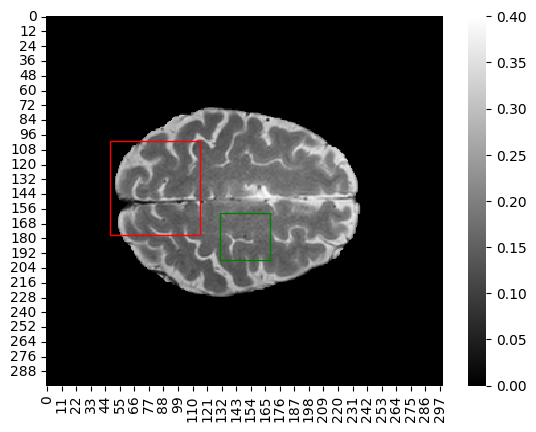

Ground truth bounding boxes: [[[ 25.78125 159.375    98.4375  232.03125]]]
Predicted bounding boxes: [[56.69873809814453, 115.7269058227539, 113.92369842529297, 193.1394805908203]]


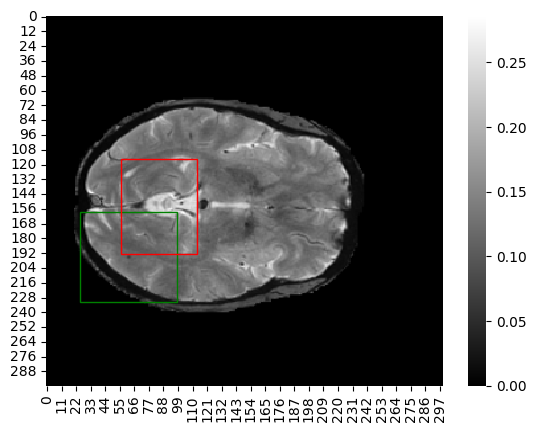

Ground truth bounding boxes: [[[104.296875 139.453125 178.125    212.109375]]]
Predicted bounding boxes: [[99.94952392578125, 104.32917785644531, 135.3660430908203, 161.77947998046875]]


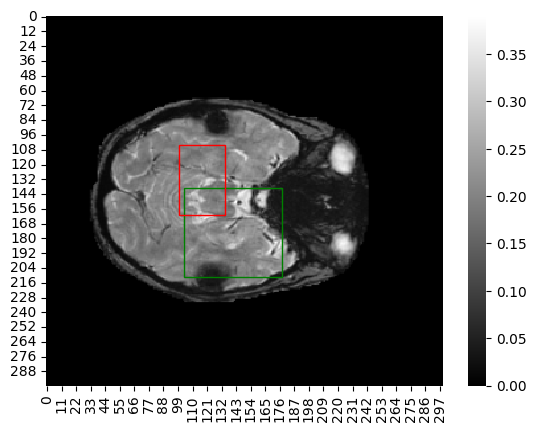

In [33]:

for index, case in enumerate(vl):
    for i in range(len(case)):
        s, m, t, c = case[i]

        x = s.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
        T = m.squeeze(1).float().to(device)

        y = model(x, t)
        bboxes = m[t].cpu().numpy()
        print('Ground truth bounding boxes:', bboxes)

        y = (y * 300).squeeze().detach().cpu().tolist()
        if isinstance(y[0], list):  
            predicted_bboxes = y
        else:  
            predicted_bboxes = [y]

        print('Predicted bounding boxes:', predicted_bboxes)

        fig, ax = plt.subplots()
        ax = sns.heatmap(x[t][0].squeeze().cpu(), cmap='gray')

        for bbox in bboxes[0]: 
            truth = patches.Rectangle(
                (bbox[0], bbox[1]), 
                bbox[2] - bbox[0],  
                bbox[3] - bbox[1], 
                linewidth=1, edgecolor='g', facecolor='none'
            )
            ax.add_patch(truth)

        for p in predicted_bboxes:
            pred = patches.Rectangle(
                (p[0], p[1]),
                p[2] - p[0],
                p[3] - p[1],
                linewidth=1, edgecolor='r', facecolor='none'
            )
            ax.add_patch(pred)

        plt.show()


In [34]:
save_model = config['model']
filename = f'RPN_cohorts_1_3_50_epochs_mse_loss_{dte}.pt'
torch.save(model.state_dict(), filename)